In [3]:
%load_ext autoreload
%autoreload 2

import os
import time
import glob
import re
import pandas as pd
from functools import reduce
from klepto.archives import dir_archive

import numpy as np
from tqdm.auto import tqdm
import coffea.processor as processor
from coffea.processor.accumulator import AccumulatorABC
from coffea.analysis_objects import JaggedCandidateArray
from coffea.btag_tools import BTagScaleFactor
from coffea import hist
import pandas as pd
import uproot_methods
import uproot
import awkward
import copy

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from Tools.config_helpers import *
from Tools.helpers import mergeArray, mt, get_scheduler_address

from Tools.objects import Collections
from Tools.cutflow import Cutflow

# This just tells matplotlib not to open any
# interactive windows.
matplotlib.use('Agg')

In [4]:
def pad_and_flatten(val): 
    try:
        return val.pad(1, clip=True).fillna(0.).flatten()
    except AttributeError:
        return val.flatten()


In [5]:
#global variables... to avoid making bugs!!!
processesList = ['mC750_l1', 'WJets', 'TTJets', 'ST', 'ttW', 'WW', 'ZNuNu', 'QCD', 'Data']


In [6]:
from Tools.WH_objects import *
from Tools.WH_scalefactors import LeptonSF
from Tools.WH_deepAK8 import getWTagSF

In [20]:
year = 2017

class analysisProcessor(processor.ProcessorABC):
    """Processor used for running the analysis"""
    def __init__(self):
        
        # we can use a large number of bins and rebin later
        dataset_axis        = hist.Cat("dataset",   "Primary dataset")
        pt_axis             = hist.Bin("pt",        r"$p_{T}$ (GeV)", 1000, 0, 1000)
        p_axis              = hist.Bin("p",         r"$p$ (GeV)", 1000, 0, 2500)
        ht_axis             = hist.Bin("ht",        r"$H_{T}$ (GeV)", 500, 0, 5000)
        mass_axis           = hist.Bin("mass",      r"M (GeV)", 1000, 0, 2000)
        eta_axis            = hist.Bin("eta",       r"$\eta$", 60, -5.5, 5.5)
        delta_axis          = hist.Bin("delta",     r"$\delta$", 100,0,10 )
        score_axis          = hist.Bin("score",     r"$score$", 100,0,1 )
        multiplicity_axis   = hist.Bin("multiplicity",         r"N", 20, -0.5, 19.5)
        norm_axis           = hist.Bin("norm",         r"N", 25, 0, 1)

        self._accumulator = processor.dict_accumulator({
            
            "met_CR":           hist.Hist("Counts", dataset_axis, pt_axis),
            "met_VR":           hist.Hist("Counts", dataset_axis, pt_axis),
            "met_baseline":     hist.Hist("Counts", dataset_axis, pt_axis),
            "met_Higgs_CR":     hist.Hist("Counts", dataset_axis, pt_axis),
            "met_W_CR":         hist.Hist("Counts", dataset_axis, pt_axis),
            "met_Higgs_W_CR":   hist.Hist("Counts", dataset_axis, pt_axis),
            
            "ht_CR":            hist.Hist("Counts", dataset_axis, ht_axis),
            "ht_Higgs_CR":      hist.Hist("Counts", dataset_axis, ht_axis),
            "ht_W_CR":          hist.Hist("Counts", dataset_axis, ht_axis),
            "ht_Higgs_W_CR":    hist.Hist("Counts", dataset_axis, ht_axis),
            
            "N_AK8_CR" :        hist.Hist("Counts", dataset_axis, multiplicity_axis),
            "N_H_CR" :          hist.Hist("Counts", dataset_axis, multiplicity_axis),
            "N_W_CR" :          hist.Hist("Counts", dataset_axis, multiplicity_axis),
            "N_W_CR_WSFUp" :    hist.Hist("Counts", dataset_axis, multiplicity_axis),
            "N_W_CR_WSFDown" :  hist.Hist("Counts", dataset_axis, multiplicity_axis),
            "N_W_1b_CR" :       hist.Hist("Counts", dataset_axis, multiplicity_axis),
            "N_W_1b_CR_WSFUp" : hist.Hist("Counts", dataset_axis, multiplicity_axis),
            "N_W_1b_CR_WSFDown": hist.Hist("Counts", dataset_axis, multiplicity_axis),
            "N_W_0b_CR" :       hist.Hist("Counts", dataset_axis, multiplicity_axis),
            "N_W_0b_CR_WSFUp" : hist.Hist("Counts", dataset_axis, multiplicity_axis),
            "N_W_0b_CR_WSFDown": hist.Hist("Counts", dataset_axis, multiplicity_axis),
            'N_W_1b_1j_CR':     hist.Hist("Counts", dataset_axis, multiplicity_axis),
            'N_W_1b_1j_CR_WSFUp':     hist.Hist("Counts", dataset_axis, multiplicity_axis),
            'N_W_1b_1j_CR_WSFDown':     hist.Hist("Counts", dataset_axis, multiplicity_axis),
            "W_pt_CR" :         hist.Hist("Counts", dataset_axis, pt_axis),
            "H_pt_CR" :         hist.Hist("Counts", dataset_axis, pt_axis),
            "W_eta_CR" :        hist.Hist("Counts", dataset_axis, eta_axis),
            "H_eta_CR" :        hist.Hist("Counts", dataset_axis, eta_axis),
            
            "lead_AK8_pt":      hist.Hist("Counts", dataset_axis, pt_axis),
            "lead_AK8_eta":     hist.Hist("Counts", dataset_axis, eta_axis),
            "lead_AK8_Hscore":  hist.Hist("Counts", dataset_axis, score_axis),
            "lead_AK8_Wscore":  hist.Hist("Counts", dataset_axis, score_axis),
            "lead_AK8_mass":    hist.Hist("Counts", dataset_axis, mass_axis),
            "lead_AK8_msoftdrop":  hist.Hist("Counts", dataset_axis, mass_axis),
            
            "sublead_AK8_pt":      hist.Hist("Counts", dataset_axis, pt_axis),
            "sublead_AK8_eta":     hist.Hist("Counts", dataset_axis, eta_axis),
            "sublead_AK8_Hscore":  hist.Hist("Counts", dataset_axis, score_axis),
            "sublead_AK8_Wscore":  hist.Hist("Counts", dataset_axis, score_axis),
            "sublead_AK8_mass":    hist.Hist("Counts", dataset_axis, mass_axis),
            "sublead_AK8_msoftdrop":  hist.Hist("Counts", dataset_axis, mass_axis),
            
            "N_AK8_Higgs_CR" :  hist.Hist("Counts", dataset_axis, multiplicity_axis),
            "W_pt_Higgs_CR" :   hist.Hist("Counts", dataset_axis, pt_axis),
            "H_pt_Higgs_CR" :   hist.Hist("Counts", dataset_axis, pt_axis),
            "W_eta_Higgs_CR" :  hist.Hist("Counts", dataset_axis, eta_axis),
            "H_eta_Higgs_CR" :  hist.Hist("Counts", dataset_axis, eta_axis),
            
            "N_AK8_W_CR" :      hist.Hist("Counts", dataset_axis, multiplicity_axis),
            "W_pt_W_CR" :       hist.Hist("Counts", dataset_axis, pt_axis),
            "H_pt_W_CR" :       hist.Hist("Counts", dataset_axis, pt_axis),
            "W_eta_W_CR" :      hist.Hist("Counts", dataset_axis, eta_axis),
            "H_eta_W_CR" :      hist.Hist("Counts", dataset_axis, eta_axis),
            
            "N_AK8_Higgs_W_CR" :hist.Hist("Counts", dataset_axis, multiplicity_axis),
            "W_pt_Higgs_W_CR" : hist.Hist("Counts", dataset_axis, pt_axis),
            "H_pt_Higgs_W_CR" : hist.Hist("Counts", dataset_axis, pt_axis),
            "W_eta_Higgs_W_CR" :hist.Hist("Counts", dataset_axis, eta_axis),
            "H_eta_Higgs_W_CR" :hist.Hist("Counts", dataset_axis, eta_axis),

            "N_b_baseline" :    hist.Hist("Counts", dataset_axis, multiplicity_axis),
            "N_AK4_baseline" :  hist.Hist("Counts", dataset_axis, multiplicity_axis),
            "N_AK4_extra_baseline" :  hist.Hist("Counts", dataset_axis, multiplicity_axis),
            "N_AK8_baseline" :  hist.Hist("Counts", dataset_axis, multiplicity_axis),
            "min_dphiFatJetMet4": hist.Hist("Counts", dataset_axis, delta_axis),
            "dphiDiFatJet":     hist.Hist("Counts", dataset_axis, delta_axis),
            "N_H" :             hist.Hist("Counts", dataset_axis, multiplicity_axis),
            "N_W" :             hist.Hist("Counts", dataset_axis, multiplicity_axis),
            
            'mC750_l1':         processor.defaultdict_accumulator(int),
            'WJets':            processor.defaultdict_accumulator(int),
            'QCD':              processor.defaultdict_accumulator(int),
            'TTJets':           processor.defaultdict_accumulator(int),
            'ZNuNu':            processor.defaultdict_accumulator(int),
            'ST':               processor.defaultdict_accumulator(int),
            'ST_tW':            processor.defaultdict_accumulator(int),
            'ST_tChannel':      processor.defaultdict_accumulator(int),
            'ST_sChannel':      processor.defaultdict_accumulator(int),
            'ttW':              processor.defaultdict_accumulator(int),
            'ttZ':              processor.defaultdict_accumulator(int),
            'WW':               processor.defaultdict_accumulator(int),
            'WZ/ZZ':            processor.defaultdict_accumulator(int),
            'LL':               processor.defaultdict_accumulator(int),
            'Data':             processor.defaultdict_accumulator(int),
            'totalEvents':      processor.defaultdict_accumulator(int),
            'test1':            processor.defaultdict_accumulator(float),
        })

    @property
    def accumulator(self):
        return self._accumulator

    def process(self, df):
        """
        Processing function. This is where the actual analysis happens.
        """
        output = self.accumulator.identity()
        dataset = df["dataset"]
        cfg = loadConfig()
        
        ## MET -> can switch to puppi MET
        met_pt  = df["MET_pt"]  if not year==2017 else df["METFixEE2017_pt"]
        met_phi = df["MET_phi"] if not year==2017 else df["METFixEE2017_phi"]
        
        filters  = getFilters(df, year=year, dataset=dataset)
        triggers = getTriggers(df, year=year, dataset=dataset)
        
        muon_veto     = getMuons(df, WP='veto')
        electron_veto = getElectrons(df, WP='veto')
        #muon_med      = getMuons(df, WP='medium')
        #electron_med  = getElectrons(df, WP='medium')
        fatjet        = getFatJets(df)
        jet           = getJets(df)

        sf = LeptonSF(year=year)
        leptonSF = sf.get(electron_veto, muon_veto)
        
        # clean AK4 jets
        skimjet   = jet[(jet.pt>30) & (jet.jetId>1) & (abs(jet.eta)<2.4)]
        jet       = jet[~jet.match(muon_veto, deltaRCut=0.4)] # remove jets that overlap with muons
        jet       = jet[~jet.match(electron_veto, deltaRCut=0.4)] # remove jets that overlap with electrons
        jet       = jet[jet.pt.argsort(ascending=False)] # sort the jets
        extrajet  = jet[~jet.match(fatjet, deltaRCut=0.8)] # remove AK4 jets that overlap with AK8 jets
        btag      = getBTags(jet, year=year)
        
        # some gymnastics with AK8 jets
        leadingFatJets = fatjet[:,:2]
        leadingFatJet = fatjet[:,:1]
        subleadingFatJet = fatjet[:,1:2]
        
        difatjet = leadingFatJets.choose(2)
        dphiDiFatJet = np.arccos(np.cos(difatjet.i0.phi-difatjet.i1.phi))
        min_dphiFatJetMet4 = np.arccos(np.cos(fatjet[:,:4].phi-met_phi)).min()
        
        htag = getHTags(fatjet, year=year)        
        lead_htag = htag[htag.pt.argmax()]
        
        wtag = getWTags(fatjet, year=year)
        wtag = wtag[~wtag.match(htag, deltaRCut=0.8)]
        lead_wtag = wtag[wtag.pt.argmax()]
        
        if dataset.lower().count('data')==0:
            GenW = getGenW(df)
            wtag_SF = getWTagSF(wtag, GenW, year=year)
            wtag_SFUp = getWTagSF(wtag, GenW, year=year, sigma=1) / wtag_SF # this makes life a bit easier down stream
            wtag_SFDown = getWTagSF(wtag, GenW, year=year, sigma=-1) / wtag_SF
        
        wh = lead_htag.cross(lead_wtag)
        wh_deltaPhi = np.arccos(np.cos(wh.i0.phi - wh.i1.phi))
        wh_deltaR = wh.i0.p4.delta_r(wh.i1.p4)
                
        mth = mt(htag.pt, htag.phi, met_pt, met_phi)

        ht = jet.pt.sum()

        wtag_sel = ( wtag.counts>0 & (abs(wtag.msoftdrop-80)<30).any())
        htag_sel = ( htag.counts>0 & (abs(htag.msoftdrop-125)<25).any())
        #stitchVar = 1 if dataset=='Data' else df["stitch"]
        
        ## define selections (maybe move to a different file at some point)
        
        output['totalEvents']['all'] += len(df['weight'])
        
        # Cutflow
        processes   = processesList
        weight      = np.ones(len(df['weight'])) if dataset=='Data' else df['weight']*df['puWeight']*leptonSF*wtag_SF
        lumis       = {2016: 36., 2017: 41.5, 2018: 60.}
        cfg['lumi'] = 1 if dataset=='Data' else lumis[year]
        fullweight  = weight*cfg['lumi']
        
        VR_selection = filters & triggers & ((electron_veto.counts+muon_veto.counts)==0) & (met_pt>250) & (fatjet.counts>1)
        VR_selection &= (min_dphiFatJetMet4>0.5) & (dphiDiFatJet<2.5).all() & ((htag.counts>0) & (htag.msoftdrop>180).all())
        
        cutflow = Cutflow(output, df, cfg, processes, weight=weight)
        
        cutflow.addRow( 'filters',    filters )
        cutflow.addRow( 'triggers',   triggers )
        
        #cutflow.addRow( 'stitch',   (stitchVar ==1) )
        
        cutflow.addRow( 'skim',        ((met_pt>200) & (skimjet.counts>1)) )
        #cutflow.addRow( 'Exactly 1 e or mu',   ((electron_med.counts+muon_med.counts)==1) )
        cutflow.addRow( 'E/mu veto',   ((electron_veto.counts+muon_veto.counts)==1) )
        cutflow.addRow( 'MET>250',     (met_pt>250) )
        #cutflow.addRow( 'nJet>1',      (jet.counts>1) )
        #cutflow.addRow( 'nBTag>0',     (btag.counts>0) )
        
        baseline = copy.deepcopy(cutflow.selection)
        
        cutflow.addRow( 'N_fatjet>1',      (fatjet.counts>1) )
        cutflow.addRow( 'min_dphiFatJetMet4', (min_dphiFatJetMet4>0.5))
        cutflow.addRow( 'dphiDiFatJet', (dphiDiFatJet<2.5).all() ) # by using .all() I do not implicitely cut on the number of fat jets
        #cutflow.addRow( 'minmth>200',   (mth.min()>200) )
        

        vetoQCD = copy.deepcopy(cutflow.selection)
        
        cutflow.addRow( 'N_htag>0',     (htag_sel))
        cutflow.addRow( 'njet veto',     (extrajet.counts<2))
        cutflow.addRow( 'minmth>200',   (mth.min()>200) )

        htag_selection = copy.deepcopy(cutflow.selection)
        
        cutflow.addRow( 'N_wtag>0',     (wtag_sel))
        
        wtag_selection = copy.deepcopy(cutflow.selection)
        
        cutflow.addRow( 'N_htag>0, N_wtag>0',     (htag_sel & wtag_sel))

        signal_selection = cutflow.selection
        
        ### And fill the histograms
        output['met_baseline'].fill(dataset=dataset, pt=met_pt[baseline].flatten(), weight=fullweight[baseline])
        output['N_AK4_baseline'].fill(dataset=dataset, multiplicity=jet[baseline].counts, weight=fullweight[baseline])
        #output['N_AK4_extra_baseline'].fill(dataset=dataset, multiplicity=jet[baseline].counts, weight=fullweight[baseline])
        output['N_AK8_baseline'].fill(dataset=dataset, multiplicity=fatjet[baseline].counts, weight=fullweight[baseline])
        output['N_b_baseline'].fill(dataset=dataset, multiplicity=btag[baseline].counts, weight=fullweight[baseline])
        output['min_dphiFatJetMet4'].fill(dataset=dataset, delta=min_dphiFatJetMet4[(baseline&(fatjet.counts>1))].flatten(), weight=fullweight[(baseline&(fatjet.counts>1))])
        output['dphiDiFatJet'].fill(dataset=dataset, delta=dphiDiFatJet[(baseline&(fatjet.counts>1))].flatten(), weight=fullweight[(baseline&(fatjet.counts>1))])
        
        output['met_CR'].fill(dataset=dataset, pt=met_pt[vetoQCD].flatten(), weight=fullweight[vetoQCD])
        output['met_VR'].fill(dataset=dataset, pt=met_pt[VR_selection].flatten(), weight=fullweight[VR_selection])
        output['met_W_CR'].fill(dataset=dataset, pt=met_pt[vetoQCD & wtag_sel].flatten(), weight=fullweight[vetoQCD & wtag_sel])
        output['met_Higgs_CR'].fill(dataset=dataset, pt=met_pt[vetoQCD & htag_sel].flatten(), weight=fullweight[vetoQCD & htag_sel])
        output['met_Higgs_W_CR'].fill(dataset=dataset, pt=met_pt[signal_selection].flatten(), weight=fullweight[signal_selection])

        output['lead_AK8_pt'].fill(dataset=dataset, pt=leadingFatJet[vetoQCD].pt.flatten(), weight=fullweight[vetoQCD])
        output['lead_AK8_eta'].fill(dataset=dataset, eta=leadingFatJet[vetoQCD].eta.flatten(), weight=fullweight[vetoQCD])
        output['lead_AK8_mass'].fill(dataset=dataset, mass=leadingFatJet[vetoQCD].mass.flatten(), weight=fullweight[vetoQCD])
        output['lead_AK8_msoftdrop'].fill(dataset=dataset, mass=leadingFatJet[vetoQCD].msoftdrop.flatten(), weight=fullweight[vetoQCD])
        output['lead_AK8_Hscore'].fill(dataset=dataset, score=leadingFatJet[vetoQCD].deepTagMD_HbbvsQCD.flatten(), weight=fullweight[vetoQCD])
        output['lead_AK8_Wscore'].fill(dataset=dataset, score=leadingFatJet[vetoQCD].deepTag_WvsQCD.flatten(), weight=fullweight[vetoQCD])

        output['sublead_AK8_pt'].fill(dataset=dataset, pt=subleadingFatJet[vetoQCD].pt.flatten(), weight=fullweight[vetoQCD])
        output['sublead_AK8_eta'].fill(dataset=dataset, eta=subleadingFatJet[vetoQCD].eta.flatten(), weight=fullweight[vetoQCD])
        output['sublead_AK8_mass'].fill(dataset=dataset, mass=subleadingFatJet[vetoQCD].mass.flatten(), weight=fullweight[vetoQCD])
        output['sublead_AK8_msoftdrop'].fill(dataset=dataset, mass=subleadingFatJet[vetoQCD].msoftdrop.flatten(), weight=fullweight[vetoQCD])
        output['sublead_AK8_Hscore'].fill(dataset=dataset, score=subleadingFatJet[vetoQCD].deepTagMD_HbbvsQCD.flatten(), weight=fullweight[vetoQCD])
        output['sublead_AK8_Wscore'].fill(dataset=dataset, score=subleadingFatJet[vetoQCD].deepTag_WvsQCD.flatten(), weight=fullweight[vetoQCD])
        
        output['N_H_CR'].fill(dataset=dataset, multiplicity=htag[vetoQCD].counts, weight=fullweight[vetoQCD])
        output['N_W_CR'].fill(dataset=dataset, multiplicity=wtag[vetoQCD].counts, weight=fullweight[vetoQCD])
        if dataset.lower().count('data')==0:
            output['N_W_CR_WSFUp'].fill(dataset=dataset, multiplicity=wtag[vetoQCD].counts, weight=(fullweight*wtag_SFUp)[vetoQCD])
            output['N_W_CR_WSFDown'].fill(dataset=dataset, multiplicity=wtag[vetoQCD].counts, weight=(fullweight*wtag_SFDown)[vetoQCD])
        
        output['N_W_1b_CR'].fill(dataset=dataset, multiplicity=wtag[vetoQCD & (btag.counts>0)].counts, weight=fullweight[vetoQCD & (btag.counts>0)])
        if dataset.lower().count('data')==0:
            output['N_W_1b_CR_WSFUp'].fill(dataset=dataset, multiplicity=wtag[vetoQCD & (btag.counts>0)].counts, weight=(fullweight*wtag_SFUp)[vetoQCD & (btag.counts>0)])
            output['N_W_1b_CR_WSFDown'].fill(dataset=dataset, multiplicity=wtag[vetoQCD & (btag.counts>0)].counts, weight=(fullweight*wtag_SFDown)[vetoQCD & (btag.counts>0)])

        output['N_W_1b_1j_CR'].fill(dataset=dataset, multiplicity=wtag[vetoQCD & (btag.counts>0) & (extrajet.counts<2)].counts, weight=fullweight[vetoQCD & (btag.counts>0) & (extrajet.counts<2)])
        if dataset.lower().count('data')==0:
            output['N_W_1b_1j_CR_WSFUp'].fill(dataset=dataset, multiplicity=wtag[vetoQCD & (btag.counts>0) & (extrajet.counts<2)].counts, weight=(fullweight*wtag_SFUp)[vetoQCD & (btag.counts>0) & (extrajet.counts<2)])
            output['N_W_1b_1j_CR_WSFDown'].fill(dataset=dataset, multiplicity=wtag[vetoQCD & (btag.counts>0) & (extrajet.counts<2)].counts, weight=(fullweight*wtag_SFDown)[vetoQCD & (btag.counts>0) & (extrajet.counts<2)])

        output['N_W_0b_CR'].fill(dataset=dataset, multiplicity=wtag[vetoQCD & (btag.counts==0)].counts, weight=fullweight[vetoQCD & (btag.counts==0)])
        if dataset.lower().count('data')==0:
            output['N_W_0b_CR_WSFUp'].fill(dataset=dataset, multiplicity=wtag[vetoQCD & (btag.counts==0)].counts, weight=(fullweight*wtag_SFUp)[vetoQCD & (btag.counts==0)])
            output['N_W_0b_CR_WSFDown'].fill(dataset=dataset, multiplicity=wtag[vetoQCD & (btag.counts==0)].counts, weight=(fullweight*wtag_SFDown)[vetoQCD & (btag.counts==0)])
        
        output['ht_CR'].fill(dataset=dataset, ht=ht[vetoQCD].flatten(), weight=fullweight[vetoQCD])
        output['ht_W_CR'].fill(dataset=dataset, ht=ht[vetoQCD & wtag_sel].flatten(), weight=fullweight[vetoQCD & wtag_sel])
        output['ht_Higgs_CR'].fill(dataset=dataset, ht=ht[vetoQCD & htag_sel].flatten(), weight=fullweight[vetoQCD & htag_sel])
        output['ht_Higgs_W_CR'].fill(dataset=dataset, ht=ht[signal_selection].flatten(), weight=fullweight[signal_selection])
        
        output['N_AK8_CR'].fill(dataset=dataset, multiplicity=fatjet[vetoQCD].counts, weight=fullweight[vetoQCD])

        output['N_AK8_W_CR'].fill(dataset=dataset, multiplicity=fatjet[vetoQCD & wtag_sel].counts, weight=fullweight[vetoQCD & wtag_sel])
        output['W_pt_W_CR'].fill(dataset=dataset, pt=lead_wtag[vetoQCD & wtag_sel].pt.flatten(), weight=fullweight[vetoQCD & wtag_sel])
        output['W_eta_W_CR'].fill(dataset=dataset, eta=lead_wtag[vetoQCD & wtag_sel].eta.flatten(), weight=fullweight[vetoQCD & wtag_sel])

        output['N_AK8_Higgs_CR'].fill(dataset=dataset, multiplicity=fatjet[vetoQCD & htag_sel].counts, weight=fullweight[vetoQCD & htag_sel])
        output['H_pt_Higgs_CR'].fill(dataset=dataset, pt=lead_htag[vetoQCD & htag_sel].pt.flatten(), weight=fullweight[vetoQCD & htag_sel])
        output['H_eta_Higgs_CR'].fill(dataset=dataset, eta=lead_htag[vetoQCD & htag_sel].eta.flatten(), weight=fullweight[vetoQCD & htag_sel])

        output['N_AK8_Higgs_W_CR'].fill(dataset=dataset, multiplicity=fatjet[signal_selection].counts, weight=fullweight[signal_selection])
        output['W_pt_Higgs_W_CR'].fill(dataset=dataset, pt=lead_wtag[signal_selection].pt.flatten(), weight=fullweight[signal_selection])
        output['H_pt_Higgs_W_CR'].fill(dataset=dataset, pt=lead_htag[signal_selection].pt.flatten(), weight=fullweight[signal_selection])
        output['W_eta_Higgs_W_CR'].fill(dataset=dataset, eta=lead_wtag[signal_selection].eta.flatten(), weight=fullweight[signal_selection])
        output['H_eta_Higgs_W_CR'].fill(dataset=dataset, eta=lead_htag[signal_selection].eta.flatten(), weight=fullweight[signal_selection])

                
        return output

    def postprocess(self, accumulator):
        return accumulator

In [21]:
runLocal = True

scheduler_address = get_scheduler_address()

if not runLocal:
    # Get the scheduler from the dask_cluster notebook
    from dask.distributed import Client, progress

    c = Client(scheduler_address)

    ## for dask
    exe_args = {
        'client': c,
        #'savemetrics': True,
    }
    exe = processor.dask_executor
    
else:
    ## for local
    exe_args = {
        'workers': 4,
        'function_args': {'flatten': False}
    }
    exe = processor.futures_executor

if not runLocal:
    print(c)

In [22]:
overwrite = True
small = False

from Tools.WH_samples import * #fileset_2016, fileset_2016_small

if year == 2016:
    fileset_year = fileset_2016
    fileset_year_small = fileset_2016_small
elif year == 2017:
    fileset_year = fileset_2017
    fileset_year_small = fileset_2017_small
elif year == 2018:
    fileset_year = fileset_2018
    fileset_year_small = fileset_2018_small


fileset   = {'WJets': fileset_year['WJets'],
                'TTJets': fileset_year['TTJets'],
                'ST': fileset_year['ST'],
                'WW': fileset_year['WW'],
                'ttW': fileset_year['TTW'],
                'QCD': fileset_year['QCD'],
                'ZNuNu': fileset_year['ZNuNu'] + fileset_year['TTZ'] + fileset_year['VV'],
                'Data': fileset_year['MET'],
                }

fileset_small   = {'WJets': fileset_year_small['WJets'],
                'TTJets': fileset_year_small['TTJets'],
                'ST': fileset_year_small['ST'],
                'WW': fileset_year_small['WW'],
                'ttW': fileset_year_small['TTW'],
                'QCD': fileset_year_small['QCD'],
                'ZNuNu': fileset_year_small['ZNuNu'] + fileset_year_small['TTZ'] + fileset_year_small['VV'],
                'Data': fileset_year_small['MET'],
                }



# load the config and the cache
cfg = loadConfig()

cacheName = 'WH_LL_%s_small'%year if small else 'WH_LL_%s'%year

## WH_LL cache contains the plots for "resolved" like CRs

# histograms
histograms = []
histograms += ['N_AK4']

# initialize cache
cache = dir_archive(os.path.join(os.path.expandvars(cfg['caches']['base']), cacheName), serialized=True)
if not overwrite:
    cache.load()

if cfg == cache.get('cfg') and histograms == cache.get('histograms') and cache.get('simple_output'):
    output = cache.get('simple_output')

else:
    # Run the processor
    if small:
        fileset = fileset_small
        exe_args['workers'] = 4
    else:
        fileset = fileset
        exe_args['workers'] = 16
    
        
    output = processor.run_uproot_job(fileset,
                                      treename='Events',
                                      processor_instance=analysisProcessor(),
                                      executor=exe,
                                      executor_args=exe_args,
                                      #chunksize=250000,
                                      chunksize=100000,
                                     )
    cache['fileset']        = fileset
    cache['cfg']            = cfg
    cache['histograms']     = histograms
    cache['simple_output']  = output
    cache.dump()

In [13]:
def addUncertainties(ax, axis, h, selection, up_vars, down_vars, overflow='over', rebin=False):
    
    
    if rebin:
        h = h.rebin(axis, rebin)
    
    bins = h[selection].axis(axis).edges(overflow=overflow)
    
    values = h[selection].sum('dataset').values(overflow=overflow, sumw2=True)[()]
    central = values[0]
    stats = values[1]
    
    up = np.zeros_like(central)
    down = np.zeros_like(central)
    
    for up_var in up_vars:
        if rebin:
            up_var = up_var.rebin(axis, rebin)
        up += (up_var[selection].sum('dataset').values(overflow=overflow, sumw2=False)[()] - central)**2
    
    for down_var in down_vars:
        if rebin:
            down_var = down_var.rebin(axis, rebin)
        down += (down_var[selection].sum('dataset').values(overflow=overflow, sumw2=False)[()] - central)**2
    
    up   += stats 
    down += stats
    
    up = central + np.sqrt(up)
    down = central - np.sqrt(down)
    
    opts = {'step': 'post', 'label': 'Uncertainty', 'hatch': '///',
                    'facecolor': 'none', 'edgecolor': (0, 0, 0, .5), 'linewidth': 0}
    
    ax.fill_between(x=bins, y1=np.r_[down, down[-1]], y2=np.r_[up, up[-1]], **opts)

(0.0, 2000.0)

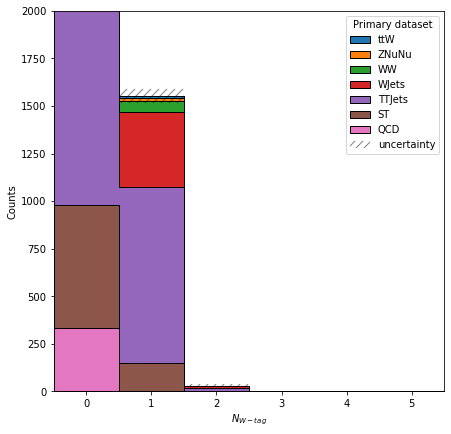

In [24]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from plots.helpers import *

import re
bkgonly = re.compile('(?!(TChiWH|Data))')


fig, ax = plt.subplots(1,1,figsize=(7,7))
rebin = hist.Bin('multiplicity', r'$N_{W-tag}$', 5, -0.5, 4.5)

histogram = output['N_W_CR'].copy()
histogram = histogram.rebin('multiplicity', rebin)

ax = hist.plot1d(histogram[bkgonly], overlay="dataset", ax=ax, stack=True, overflow='over', clear=False, line_opts=None, fill_opts=fill_opts, error_opts=error_opts)
ax.set_ylim(0,2000)

(0.0, 2000.0)

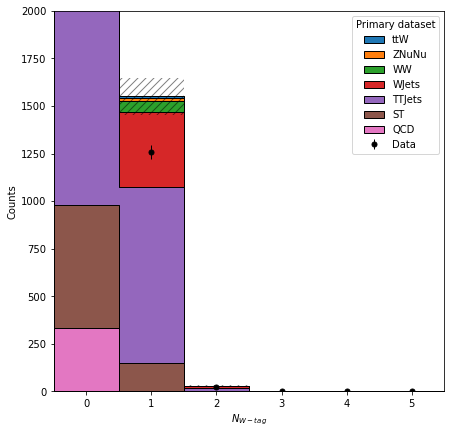

In [25]:

fig, ax = plt.subplots(1,1,figsize=(7,7))
rebin = hist.Bin('multiplicity', r'$N_{W-tag}$', 5, -0.5, 4.5)

histogram = output['N_W_CR'].copy()
histogram = histogram.rebin('multiplicity', rebin)

ax = hist.plot1d(histogram[bkgonly], overlay="dataset", ax=ax, stack=True, overflow='over', line_opts=None, fill_opts=fill_opts)
ax = hist.plot1d(histogram['Data'], overlay="dataset", ax=ax, overflow='over', error_opts=data_err_opts, clear=False)

addUncertainties(
    ax,
    'multiplicity',
    output['N_W_CR'],
    bkgonly,
    [output['N_W_CR_WSFUp']],
    [output['N_W_CR_WSFDown']],
    rebin = rebin
)

ax.set_ylim(0,2000)

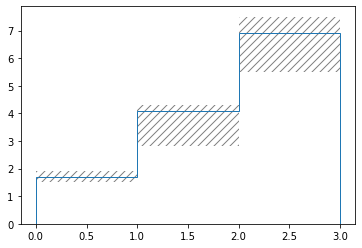

In [26]:
import yahist

opts = {'step': 'post', 'label': 'Sum unc.', 'hatch': '///',
                    'facecolor': 'none', 'edgecolor': (0, 0, 0, .5), 'linewidth': 0}

## matplotlib fill between two histos?

errors = np.array([[1.5, 1.9], [2.8, 4.3] ,[5.5, 7.5]])

h1 = yahist.Hist1D.from_bincounts(np.array([1,2,3]), np.array([0,1,2,3]), errors=np.array([0.5,2,1.7]))
h2 = yahist.Hist1D.from_bincounts(np.array([0.7,2.1,3.9]), np.array([0,1,2,3]), errors=errors[:,0])
ax = (h1+h2).plot(histtype='step')
ax.fill_between(x=np.array([0,1,2,3]), y1=np.r_[errors[:,0], errors[-1, 0]], y2=np.r_[errors[:,1], errors[-1,1]], **opts)

In [45]:
# Cutflow
from Tools.helpers import getCutFlowTable

#linesList= ['filters', 'triggers', 'skim',  'E/mu veto', 'MET>250', 'N_fatjet>1', 'min_dphiFatJetMet4', 'dphiDiFatJet', 'N_htag>0', 'njet veto', 'minmth>200', 'N_wtag>0', 'N_htag>0, N_wtag>0']
linesList= ['filters_VR', 'triggers_VR', 'E/mu veto_VR', 'MET>250_VR', 'N_fatjet>1_VR', 'min_dphiFatJetMet4_VR', 'dphiDiFatJet_VR', 'N_htag>0_VR', 'N_wtag>0_VR']


processes = processesList
lines     = ['entry_VR_VR']
lines    += linesList
df        = getCutFlowTable(output, processes=processes, lines=lines, significantFigures=4, signal='mC750_l1')
df

,mC750_l1,WJets,TTJets,ST,ttW,WW,ZNuNu,QCD,Data,S/B
entry_VR_VR,0 +/- 0.0,0 +/- 0.0,0 +/- 0.0,0 +/- 0.0,0 +/- 0.0,0 +/- 0.0,0 +/- 0.0,0 +/- 0.0,0 +/- 0.0,1
filters_VR,0 +/- 0.0,0 +/- 0.0,0 +/- 0.0,0 +/- 0.0,0 +/- 0.0,0 +/- 0.0,0 +/- 0.0,0 +/- 0.0,0 +/- 0.0,1
triggers_VR,0 +/- 0.0,0 +/- 0.0,0 +/- 0.0,0 +/- 0.0,0 +/- 0.0,0 +/- 0.0,0 +/- 0.0,0 +/- 0.0,0 +/- 0.0,1
E/mu veto_VR,0 +/- 0.0,0 +/- 0.0,0 +/- 0.0,0 +/- 0.0,0 +/- 0.0,0 +/- 0.0,0 +/- 0.0,0 +/- 0.0,0 +/- 0.0,1
MET>250_VR,0 +/- 0.0,0 +/- 0.0,0 +/- 0.0,0 +/- 0.0,0 +/- 0.0,0 +/- 0.0,0 +/- 0.0,0 +/- 0.0,0 +/- 0.0,1
N_fatjet>1_VR,0 +/- 0.0,0 +/- 0.0,0 +/- 0.0,0 +/- 0.0,0 +/- 0.0,0 +/- 0.0,0 +/- 0.0,0 +/- 0.0,0 +/- 0.0,1
min_dphiFatJetMet4_VR,0 +/- 0.0,0 +/- 0.0,0 +/- 0.0,0 +/- 0.0,0 +/- 0.0,0 +/- 0.0,0 +/- 0.0,0 +/- 0.0,0 +/- 0.0,1
dphiDiFatJet_VR,0 +/- 0.0,0 +/- 0.0,0 +/- 0.0,0 +/- 0.0,0 +/- 0.0,0 +/- 0.0,0 +/- 0.0,0 +/- 0.0,0 +/- 0.0,1
N_htag>0_VR,0 +/- 0.0,0 +/- 0.0,0 +/- 0.0,0 +/- 0.0,0 +/- 0.0,0 +/- 0.0,0 +/- 0.0,0 +/- 0.0,0 +/- 0.0,1
N_wtag>0_VR,0 +/- 0.0,0 +/- 0.0,0 +/- 0.0,0 +/- 0.0,0 +/- 0.0,0 +/- 0.0,0 +/- 0.0,0 +/- 0.0,0 +/- 0.0,1


In [46]:
# Cutflow
from Tools.helpers import getCutFlowTable

linesList= ['filters', 'triggers', 'skim',  'E/mu veto', 'MET>250', 'N_fatjet>1', 'min_dphiFatJetMet4', 'dphiDiFatJet', 'N_htag>0', 'njet veto', 'minmth>200', 'N_wtag>0', 'N_htag>0, N_wtag>0']
#linesList= ['filters_VR', 'triggers_VR', 'E/mu veto_VR', 'MET>250_VR', 'N_fatjet>1_VR', 'min_dphiFatJetMet4_VR', 'dphiDiFatJet_VR', 'N_htag>0_VR', 'N_wtag>0_VR']


processes = processesList
lines     = ['entry']
lines    += linesList
df        = getCutFlowTable(output, processes=processes, lines=lines, significantFigures=4, signal='mC750_l1')
df

,mC750_l1,WJets,TTJets,ST,ttW,WW,ZNuNu,QCD,Data,S/B
entry,0.0 +/- 0.0,3483000.0 +/- 4000.0,2009000.0 +/- 1000.0,248800.0 +/- 200.0,2300.0 +/- 5.0,129200.0 +/- 300.0,749300.0 +/- 400.0,8733000.0 +/- 49000.0,7906000.0 +/- 3000.0,0.0
filters,0.0 +/- 0.0,3475000.0 +/- 4000.0,2006000.0 +/- 1000.0,248300.0 +/- 200.0,2295.0 +/- 5.0,129000.0 +/- 300.0,748200.0 +/- 400.0,8484000.0 +/- 49000.0,5070000.0 +/- 2000.0,0.0
triggers,0.0 +/- 0.0,3475000.0 +/- 4000.0,2006000.0 +/- 1000.0,248300.0 +/- 200.0,2295.0 +/- 5.0,129000.0 +/- 300.0,748200.0 +/- 400.0,8484000.0 +/- 49000.0,3863000.0 +/- 2000.0,0.0
skim,0.0 +/- 0.0,741400.0 +/- 1300.0,370800.0 +/- 200.0,48840.0 +/- 100.0,597.4 +/- 2.5,17160.0 +/- 110.0,449200.0 +/- 300.0,543100.0 +/- 4600.0,2467000.0 +/- 2000.0,0.0
E/mu veto,0.0 +/- 0.0,348900.0 +/- 1000.0,178800.0 +/- 200.0,24420.0 +/- 70.0,280.4 +/- 1.7,8581.0 +/- 74.0,4951.0 +/- 31.0,32890.0 +/- 2410.0,627100.0 +/- 800.0,0.0
MET>250,0.0 +/- 0.0,141900.0 +/- 600.0,64700.0 +/- 90.0,9911.0 +/- 47.0,144.2 +/- 1.2,4048.0 +/- 51.0,2322.0 +/- 19.0,15990.0 +/- 1750.0,253600.0 +/- 500.0,0.0
N_fatjet>1,0.0 +/- 0.0,27490.0 +/- 210.0,19000.0 +/- 50.0,3109.0 +/- 27.0,60.32 +/- 0.82,823.2 +/- 22.8,373.0 +/- 6.6,4299.0 +/- 287.0,53200.0 +/- 230.0,0.0
min_dphiFatJetMet4,0.0 +/- 0.0,13750.0 +/- 140.0,6940.0 +/- 31.0,1094.0 +/- 16.0,32.79 +/- 0.59,375.1 +/- 15.5,246.9 +/- 4.6,762.1 +/- 150.1,23060.0 +/- 150.0,0.0
dphiDiFatJet,0.0 +/- 0.0,10450.0 +/- 120.0,4752.0 +/- 26.0,798.5 +/- 13.9,21.8 +/- 0.48,321.2 +/- 14.4,179.6 +/- 4.1,338.4 +/- 116.1,16890.0 +/- 130.0,0.0
N_htag>0,0.0 +/- 0.0,96.29 +/- 10.81,425.9 +/- 7.7,78.33 +/- 4.4,2.854 +/- 0.168,5.337 +/- 1.888,8.613 +/- 0.989,1.29 +/- 0.834,530.0 +/- 23.0,0.0


In [44]:
# Efficiencies
df = getCutFlowTable(output, processes=processes, lines=lines, significantFigures=3, absolute=False)
df

,mC750_l1,WJets,TTJets,ST,ttW,WW,ZNuNu,QCD,Data
entry,1.0,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000
filters,1.0,0.997,0.999,0.998,0.998,0.999,0.999,0.959,0.864
triggers,1.0,1.000,1.000,1.000,1.000,1.000,1.000,1.000,0.934
skim,1.0,0.226,0.184,0.170,0.302,0.112,0.601,0.081,0.637
E/mu veto,1.0,0.497,0.485,0.495,0.478,0.506,0.011,0.074,0.163
MET>250,1.0,0.428,0.377,0.398,0.500,0.472,0.473,0.531,0.402
N_fatjet>1,1.0,0.186,0.306,0.301,0.459,0.192,0.142,0.185,0.243
min_dphiFatJetMet4,1.0,0.447,0.341,0.366,0.432,0.414,0.647,0.169,0.328
dphiDiFatJet,1.0,0.744,0.667,0.728,0.647,0.823,0.725,0.182,0.723
N_htag>0,1.0,0.013,0.146,0.191,0.188,0.017,0.065,0.017,0.049
